# Aug 21st, 2022 (Degree: w/o regression, final)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Load dir

In [2]:
load_dir = pjoin(tmp_dir, 'Adjacencies')
print(load_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/Adjacencies

In [3]:
sorted(os.listdir(load_dir))

[
    'coarse-bo_bp(0.01,0.5).npy',
    'coarse-ca_bp(0.01,0.5).npy',
    'coarse-ca_bp(0.5,5.0).npy',
    'fine-bo_bp(0.01,0.5).npy',
    'fine-bo_rabies-hp.npy',
    'fine-bo_rabies-nocr.npy',
    'fine-bo_rabies-nowmcsf.npy',
    'fine-bo_rabies.npy',
    'fine-bo_raw.npy',
    'fine-ca_bp(0.01,0.5).npy',
    'fine-ca_bp(0.5,5.0).npy'
]

## Fig dir

In [4]:
fig_dir = pjoin(fig_base_dir, 'paper2.0', 'deg_all')
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/deg_all

## Load (fine, GABAN)

In [4]:
adj_fine = {}
descriptions = [
    'bo_bp(0.01,0.5)',
    'ca_bp(0.01,0.5)',
    'ca_bp(0.5,5.0)',
    # 'bo_raw',
    # 'bo_rabies-nocr',
    # 'bo_rabies-nowmcsf',
    # 'bo_rabies-hp',
]
for desc in descriptions:
    adj_fine[desc] = np.load(pjoin(load_dir, f'fine-{desc}.npy'))

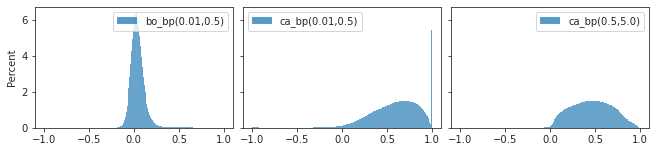

In [5]:
fig, axes = create_figure(1, 3, (9, 2), 'all', 'all', constrained_layout=True)
for i, (desc, a) in enumerate(adj_fine.items()):
    ax = axes.flat[i]
    sns.histplot(
        data=a[a.nonzero()],
        label=desc,
        bins=np.linspace(-1, 1, 201),
        stat='percent',
        ax=ax,
    )
    ax.legend()
trim_axs(axes, len(adj_fine))
plt.show()

In [6]:
deg_fine = {}
for desc, a_all in adj_fine.items():
    deg = np_nans(a_all.shape[:2])
    for i, a in enumerate(a_all):
        # Degree
        th = calculate_threshold(a, 0.15)
        th = th.pop()
        _a = a.copy()
        _a[a > th] = 1
        _a[a <= th] = 0
        deg[i] = _a.sum(0)
    deg[deg == 0] = np.nan
    deg_fine[desc] = deg
deg_fine_avg = {k: bn.nanmean(v, 0) for k, v in deg_fine.items()}

In [7]:
mice512 = Mice(512)
bs512 = Base(mice512, mode='ca2')

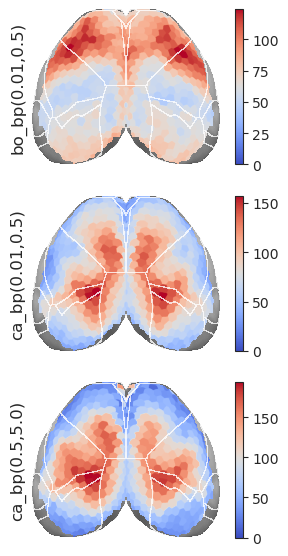

In [8]:
_ = bs512.show(
    deg_fine_avg,
    vmin=0,
    vmax=None,
    cbar=True,
    cmap='coolwarm',
    figsize=(4, 7),
)

In [9]:
len(bs512.n2l)

542

### Save individual components

In [10]:
list(adj_fine)

['bo_bp(0.01,0.5)', 'ca_bp(0.01,0.5)', 'ca_bp(0.5,5.0)']

In [11]:
deg_fine = {}
for desc, a_all in adj_fine.items():
    for d in [0.10, 0.15, 0.20, 0.25, None]:
        if d is None:
            a_all = np.maximum(0, a_all)
            deg = a_all.sum(-1)
        else:
            deg = np_nans(a_all.shape[:2])
            for i, a in enumerate(a_all):
                th = calculate_threshold(a, d)
                th = th.pop()
                _a = a.copy()
                _a[a > th] = 1
                _a[a <= th] = 0
                deg[i] = _a.sum(-1)
        deg[deg == 0] = np.nan
        deg_fine[(desc, d)] = deg
deg_fine_avg = {k: bn.nanmean(v, 0) for k, v in deg_fine.items()}
list(deg_fine_avg)

[
    ('bo_bp(0.01,0.5)', 0.1),
    ('bo_bp(0.01,0.5)', 0.15),
    ('bo_bp(0.01,0.5)', 0.2),
    ('bo_bp(0.01,0.5)', 0.25),
    ('bo_bp(0.01,0.5)', None),
    ('ca_bp(0.01,0.5)', 0.1),
    ('ca_bp(0.01,0.5)', 0.15),
    ('ca_bp(0.01,0.5)', 0.2),
    ('ca_bp(0.01,0.5)', 0.25),
    ('ca_bp(0.01,0.5)', None),
    ('ca_bp(0.5,5.0)', 0.1),
    ('ca_bp(0.5,5.0)', 0.15),
    ('ca_bp(0.5,5.0)', 0.2),
    ('ca_bp(0.5,5.0)', 0.25),
    ('ca_bp(0.5,5.0)', None)
]

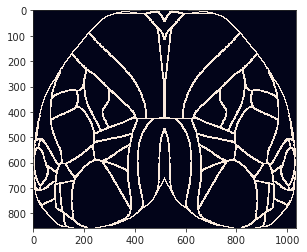

In [19]:
contour = bs512.get_contour(0.2, False)
plt.imshow(contour);

In [52]:
nn = 512
num_k = 7
perc = 15
mice = Mice(nn)

bt_dict, props_bo, props_ca = default_props(mice, num_k, perc)
for mode, o in bt_dict.items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan
good = git_good('deg', bt_dict)
good.sum()

530

In [75]:
vmins =  {
    ('bo_bp(0.01,0.5)', 0.1): 0,
    ('bo_bp(0.01,0.5)', 0.15): 0,
    ('bo_bp(0.01,0.5)', 0.2): 20,
    ('bo_bp(0.01,0.5)', 0.25): 40,
    ('bo_bp(0.01,0.5)', None): 14,
    ('ca_bp(0.01,0.5)', 0.1): 0,
    ('ca_bp(0.01,0.5)', 0.15): 0,
    ('ca_bp(0.01,0.5)', 0.2): 10,
    ('ca_bp(0.01,0.5)', 0.25): 20,
    ('ca_bp(0.01,0.5)', None): 230,
    ('ca_bp(0.5,5.0)', 0.1): 0,
    ('ca_bp(0.5,5.0)', 0.15): 0,
    ('ca_bp(0.5,5.0)', 0.2): 10,
    ('ca_bp(0.5,5.0)', 0.25): 15,
    ('ca_bp(0.5,5.0)', None): 130,
}
nbins = 4

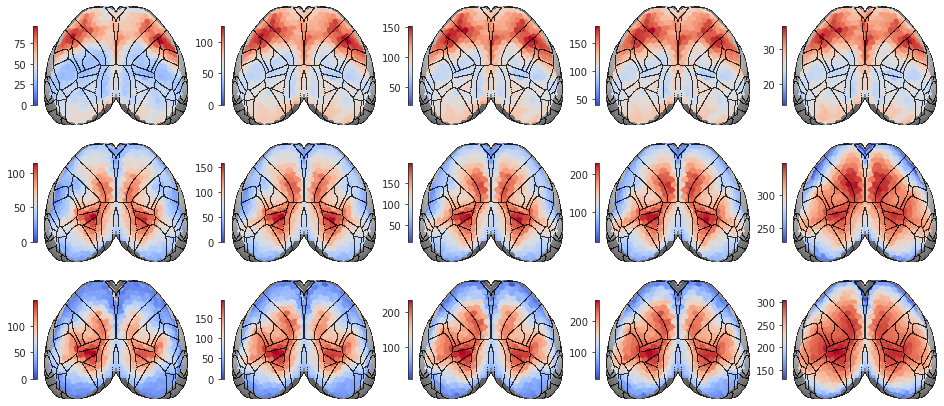

In [81]:
fig, axes = create_figure(3, 5, (13, 5.7), 'all', 'all', constrained_layout=True)
for i, desc in enumerate(adj_fine):
    for j, d in enumerate([0.10, 0.15, 0.20, 0.25, None]):
        x = deg_fine_avg[(desc, d)]
        x[x == 0] = np.nan
        if '(0.5,5.0)' in desc:
            x[~good] = np.nan
        ax = ctx2ax(
            ax=axes[i, j],
            base=bs512,
            x=x,
            vmin=vmins[(desc, d)],
            vmax=None,
            cmap='coolwarm',
            cbar_shrink=0.6,
            contour=contour,
            contour_cmap='Greys_r',
            cbar_tick_nbins=nbins,
            cbar_aspect=20,
        )
remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'fine.png'), **kws_fig)
plt.show()

## Load (Coarse, KABA)

In [5]:
adj_coarse = {}
descriptions = [
    'bo_bp(0.01,0.5)',
    'ca_bp(0.01,0.5)',
    'ca_bp(0.5,5.0)',
]
for desc in descriptions:
    adj_coarse[desc] = np.load(pjoin(load_dir, f'coarse-{desc}.npy'))

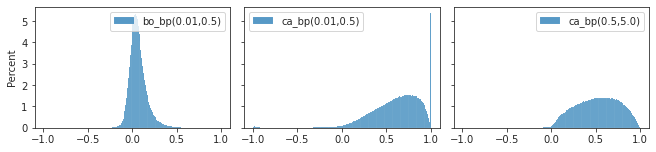

In [6]:
fig, axes = create_figure(1, 3, (9, 2), 'all', 'all', constrained_layout=True)
for i, (desc, a) in enumerate(adj_coarse.items()):
    ax = axes.flat[i]
    sns.histplot(
        data=a[a.nonzero()],
        label=desc,
        bins=np.linspace(-1, 1, 201),
        stat='percent',
        ax=ax,
    )
    ax.legend()
trim_axs(axes, len(adj_coarse))
plt.show()

In [7]:
deg_coarse = {}
for desc, a_all in adj_coarse.items():
    deg = np_nans(a_all.shape[:2])
    for i, a in enumerate(a_all):
        # Degree
        th = calculate_threshold(a, 0.15)
        th = th.pop()
        _a = a.copy()
        _a[a > th] = 1
        _a[a <= th] = 0
        deg[i] = _a.sum(0)
    deg[deg == 0] = np.nan
    deg_coarse[desc] = deg
deg_coarse_avg = {k: bn.nanmean(v, 0) for k, v in deg_coarse.items()}

In [8]:
mice128 = Mice(128)
bs128 = Base(mice128, mode='ca2')

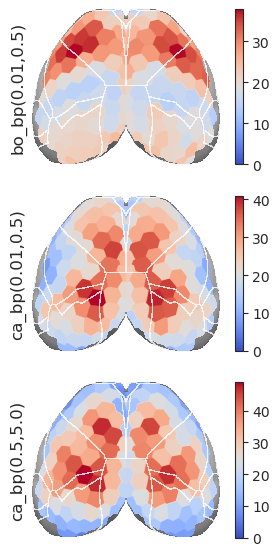

In [10]:
_ = bs128.show(
    deg_coarse_avg,
    vmin=0,
    vmax=None,
    cbar=True,
    cmap='coolwarm',
    figsize=(4, 7),
)

In [12]:
len(bs128.n2l)

152

### Save individual components

In [13]:
list(adj_coarse)

['bo_bp(0.01,0.5)', 'ca_bp(0.01,0.5)', 'ca_bp(0.5,5.0)']

In [14]:
deg_coarse = {}
for desc, a_all in adj_coarse.items():
    for d in [0.10, 0.15, 0.20, 0.25, None]:
        if d is None:
            a_all = np.maximum(0, a_all)
            deg = a_all.sum(-1)
        else:
            deg = np_nans(a_all.shape[:2])
            for i, a in enumerate(a_all):
                th = calculate_threshold(a, d)
                th = th.pop()
                _a = a.copy()
                _a[a > th] = 1
                _a[a <= th] = 0
                deg[i] = _a.sum(-1)
        deg[deg == 0] = np.nan
        deg_coarse[(desc, d)] = deg
deg_coarse_avg = {k: bn.nanmean(v, 0) for k, v in deg_coarse.items()}
list(deg_coarse_avg)

[
    ('bo_bp(0.01,0.5)', 0.1),
    ('bo_bp(0.01,0.5)', 0.15),
    ('bo_bp(0.01,0.5)', 0.2),
    ('bo_bp(0.01,0.5)', 0.25),
    ('bo_bp(0.01,0.5)', None),
    ('ca_bp(0.01,0.5)', 0.1),
    ('ca_bp(0.01,0.5)', 0.15),
    ('ca_bp(0.01,0.5)', 0.2),
    ('ca_bp(0.01,0.5)', 0.25),
    ('ca_bp(0.01,0.5)', None),
    ('ca_bp(0.5,5.0)', 0.1),
    ('ca_bp(0.5,5.0)', 0.15),
    ('ca_bp(0.5,5.0)', 0.2),
    ('ca_bp(0.5,5.0)', 0.25),
    ('ca_bp(0.5,5.0)', None)
]

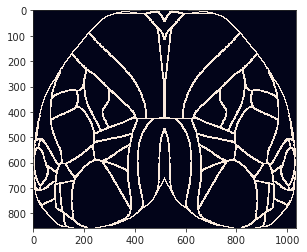

In [15]:
contour = bs128.get_contour(0.2, False)
plt.imshow(contour);

In [16]:
nn = 128
num_k = 7
perc = 15
mice = Mice(nn)

bt_dict, props_bo, props_ca = default_props(mice, num_k, perc)
for mode, o in bt_dict.items():
    o.run_deg = np.array(o.run_deg)
    o.run_deg[o.run_deg == 0] = np.nan
good = git_good('deg', bt_dict)
good.sum()

151

In [50]:
vmins =  {
    ('bo_bp(0.01,0.5)', 0.1): 0,
    ('bo_bp(0.01,0.5)', 0.15): 0,
    ('bo_bp(0.01,0.5)', 0.2): 8,
    ('bo_bp(0.01,0.5)', 0.25): 13,
    ('bo_bp(0.01,0.5)', None): 6.5,
    ('ca_bp(0.01,0.5)', 0.1): 0,
    ('ca_bp(0.01,0.5)', 0.15): 0,
    ('ca_bp(0.01,0.5)', 0.2): 2,
    ('ca_bp(0.01,0.5)', 0.25): 5,
    ('ca_bp(0.01,0.5)', None): 70,
    ('ca_bp(0.5,5.0)', 0.1): 0,
    ('ca_bp(0.5,5.0)', 0.15): 0,
    ('ca_bp(0.5,5.0)', 0.2): 2,
    ('ca_bp(0.5,5.0)', 0.25): 4,
    ('ca_bp(0.5,5.0)', None): 55,
}
nbins = 4

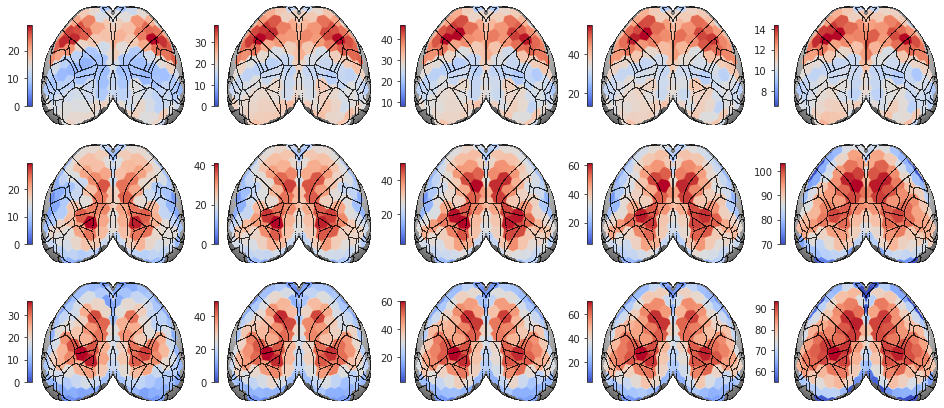

In [52]:
fig, axes = create_figure(3, 5, (13, 5.7), 'all', 'all', constrained_layout=True)
for i, desc in enumerate(adj_coarse):
    for j, d in enumerate([0.10, 0.15, 0.20, 0.25, None]):
        x = deg_coarse_avg[(desc, d)]
        x[x == 0] = np.nan
        if '(0.5,5.0)' in desc:
            x[~good] = np.nan
        ax = ctx2ax(
            ax=axes[i, j],
            base=bs128,
            x=x,
            vmin=vmins[(desc, d)],
            vmax=None,
            cmap='coolwarm',
            cbar_shrink=0.6,
            contour=contour,
            contour_cmap='Greys_r',
            cbar_tick_nbins=nbins,
            cbar_aspect=40,
        )
remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'coarse.png'), **kws_fig)
plt.show()

## Bold: other (KABA)

In [53]:
adj_fine = {}
descriptions = [
    'bo_raw',
    'bo_rabies-nocr',
    'bo_rabies-nowmcsf',
    'bo_rabies-hp',
    'bo_rabies',
]
for desc in descriptions:
    adj_fine[desc] = np.load(pjoin(load_dir, f'fine-{desc}.npy'))

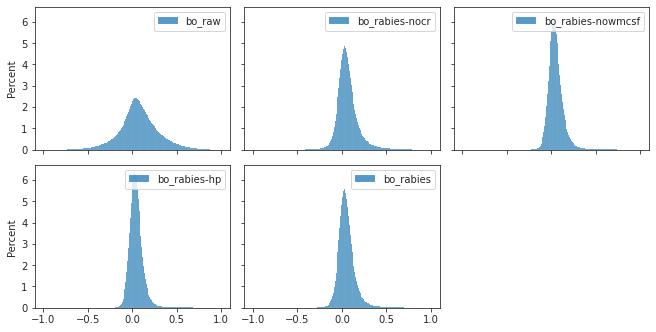

In [54]:
fig, axes = create_figure(2, 3, (9, 4.5), 'all', 'all', constrained_layout=True)
for i, (desc, a) in enumerate(adj_fine.items()):
    ax = axes.flat[i]
    sns.histplot(
        data=a[a.nonzero()],
        label=desc,
        bins=np.linspace(-1, 1, 201),
        stat='percent',
        ax=ax,
    )
    ax.legend()
trim_axs(axes, len(adj_fine))
plt.show()

In [55]:
deg_fine = {}
for desc, a_all in adj_fine.items():
    deg = np_nans(a_all.shape[:2])
    for i, a in enumerate(a_all):
        # Degree
        th = calculate_threshold(a, 0.15)
        th = th.pop()
        _a = a.copy()
        _a[a > th] = 1
        _a[a <= th] = 0
        deg[i] = _a.sum(0)
    deg[deg == 0] = np.nan
    deg_fine[desc] = deg
deg_fine_avg = {k: bn.nanmean(v, 0) for k, v in deg_fine.items()}

In [56]:
mice512 = Mice(512)
bs512 = Base(mice512, mode='ca2')

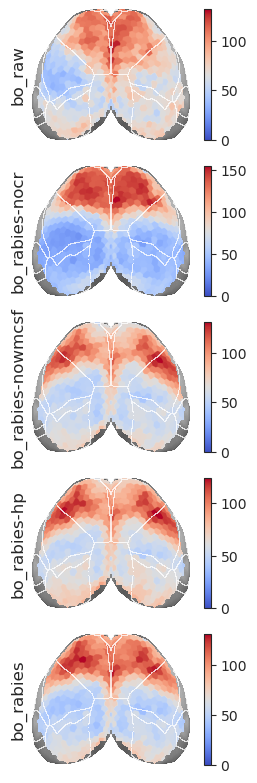

In [57]:
_ = bs512.show(
    deg_fine_avg,
    vmin=0,
    vmax=None,
    cbar=True,
    cmap='coolwarm',
    figsize=(4, 10),
)

In [58]:
len(bs512.n2l)

540

In [62]:
vmins = {
    'bo_raw': 0,
    'bo_rabies-nocr': 0,
    'bo_rabies-nowmcsf': 0,
    'bo_rabies-hp': 0,
    'bo_rabies': 0,
}

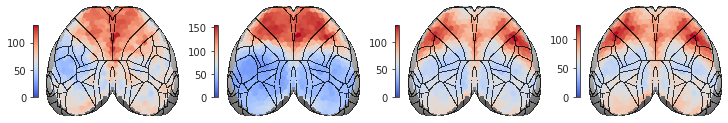

In [82]:
fig, axes = create_figure(1, 4, (10, 2), 'all', 'all', constrained_layout=True)
for i, desc in enumerate(deg_fine_avg):
    if i >= 4:
        continue
    x = deg_fine_avg[desc]
    x[x == 0] = np.nan
    ax = ctx2ax(
        ax=axes[i],
        base=bs512,
        x=x,
        vmin=vmins[desc],
        vmax=None,
        cmap='coolwarm',
        cbar_shrink=0.5,
        contour=contour,
        contour_cmap='Greys_r',
        cbar_tick_nbins=nbins,
        cbar_aspect=85,
    )
remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'bold_other.png'), **kws_fig)
plt.show()